In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import simpy
import seaborn as sns

In [31]:
# Data

d ={
    'location' : 'APAC', 
    'role' : 'SWE', 
    'ac_pi_ptr' : 0.83, 
    'pi_os_ptr' : 0.33, 
    'os_oe_ptr' : 0.18, 
    'oe_oa_ptr' : 0.87, 
    'ac_pi_lat' : 4, 
    'pi_os_lat' : 4, 
    'os_oe_lat' : 4, 
    'oe_oa_lat' : 0, 
    'ppr' : 2
}

data = pd.DataFrame([d])

# goals (in OA)

goals = pd.DataFrame(
    [
        # {'date': pd.to_datetime('2023/06/26'), 'quantity': 202, 'event': 'oa'}, 
        {'date': pd.to_datetime('2023/09/25'), 'quantity': 400, 'event': 'oa'}, 
        {'date': pd.to_datetime('2023/12/25'), 'quantity': 380, 'event': 'oa'}, 
    ]
)

# ramping 



rng = pd.date_range(
    start = pd.to_datetime('2023/03/13'), 
    end = pd.to_datetime('2023/12/25'), freq = '7D')

In [32]:
d2 = data.melt(id_vars = ['location', 'role'], 
          value_vars = [
'ac_pi_ptr',
'pi_os_ptr',
'os_oe_ptr',
'oe_oa_ptr',
'ac_pi_lat',
'pi_os_lat',
'os_oe_lat',
'oe_oa_lat',
          ]
         )

v2 = d2.variable.str.split("_")

d2 = d2.assign(
    stat = v2
)

In [33]:
d2['x'] = d2.stat.str[0]
d2['y'] = d2.stat.str[1]
d3 = d2.groupby(['location', 'role', 'x', 'y']).apply(lambda g : g['value'].values)


In [34]:
d3.name = 'stats'
d3 = d3.reset_index()

In [35]:
d3

,location,role,x,y,stats
0,APAC,SWE,ac,pi,"[0.83, 4.0]"
1,APAC,SWE,oe,oa,"[0.87, 0.0]"
2,APAC,SWE,os,oe,"[0.18, 4.0]"
3,APAC,SWE,pi,os,"[0.33, 4.0]"


In [36]:
other_goals = []
def calc_goals(goal, deadline, event): 
    
    n = d3[d3['y'] == event]
    val, l = n['stats'].values[0]
    goal /= val
    deadline -= pd.to_timedelta(l, unit = 'W')
    
    other_goals.append({'date': deadline, 'quantity': np.ceil(goal), 'event': n['x'].values[0]})
    
    try: 
        calc_goals(goal, deadline, n['x'].values[0])
    except IndexError: 
        pass


goals.apply(lambda row : calc_goals(row['quantity'], row['date'], row['event']), axis = 1)

0    None
1    None
dtype: object

        date  quantity event  goal_order
1 2023-12-25     380.0    oa         1.0
6 2023-12-25     437.0    oe         1.0
7 2023-11-27    2427.0    os         1.0
8 2023-10-30    7354.0    pi         1.0
9 2023-10-02    8860.0    ac         1.0
0 2023-09-25     400.0    oa         0.0
2 2023-09-25     460.0    oe         0.0
3 2023-08-28    2555.0    os         0.0
4 2023-07-31    7741.0    pi         0.0
5 2023-07-03    9326.0    ac         0.0


/var/folders/mn/llyzbhpx6x91l387r0kfsz2w00x9tq/T/ipykernel_29759/798234662.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dl = goals.append(other_goals).reset_index(drop = True).sort_values(by = 'date', ascending = False).fillna(method = 'ffill')


<AxesSubplot:xlabel='date', ylabel='quantity'>

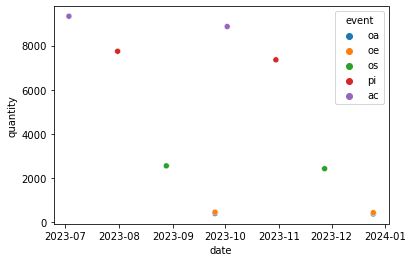

In [66]:
goals['goal_order'] = goals.date.rank() - 1
dl = goals.append(other_goals).reset_index(drop = True).sort_values(by = 'date', ascending = False).fillna(method = 'ffill')
sns.scatterplot(data = dl, x = 'date', y = 'quantity', hue = 'event')

In [74]:
def get_duration(todays_date, deadlines, ac_oa_lat): 
    durrs = []
    for deadline in deadlines: 
        durr = (deadline - todays_date).days // 7
        durrs.append(min([durr, ac_oa_lat]))
    return durrs


def realize(row, L):
    dr = pd.date_range(row['date'] - pd.Timedelta(row['durr'] + 1, unit = 'W'), row['date'], freq = 'W')
    e = np.ceil(row['quantity'] / len(dr))
    cl = row['event']

    df = pd.DataFrame()
    df['date'] = dr
    df['quantity'] = e
    df['event'] = cl

    L.append(df)
    return

In [84]:
ac_oa_ptr = data[data.columns[data.columns.str.endswith('ptr')]].prod(axis = 1)

todays_date = pd.to_datetime('2023/03/03')
deadline = dl.loc[dl.event == 'ac']['date'].values

L = []
durrs = get_duration(todays_date, deadline, 12.)
dl['durr'] = 0.
for i, durr in enumerate(durrs[::-1]): 
    dl.loc[dl.goal_order == i, 'durr'] = durr


dl.apply(realize, L = L, axis = 1)

1    None
6    None
7    None
8    None
9    None
0    None
2    None
3    None
4    None
5    None
dtype: object

In [85]:
dl

,date,quantity,event,goal_order,durr
1,2023-12-25,380.0,oa,1.0,12.0
6,2023-12-25,437.0,oe,1.0,12.0
7,2023-11-27,2427.0,os,1.0,12.0
8,2023-10-30,7354.0,pi,1.0,12.0
9,2023-10-02,8860.0,ac,1.0,12.0
0,2023-09-25,400.0,oa,0.0,12.0
2,2023-09-25,460.0,oe,0.0,12.0
3,2023-08-28,2555.0,os,0.0,12.0
4,2023-07-31,7741.0,pi,0.0,12.0
5,2023-07-03,9326.0,ac,0.0,12.0


<AxesSubplot:xlabel='date', ylabel='quantity'>

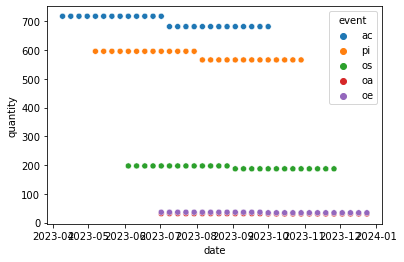

In [86]:
dll = pd.concat(L).groupby(['date', 'event'], as_index = False).sum()

sns.scatterplot(data = dll, x = 'date', y = 'quantity', hue = 'event')

In [43]:
dll2 = dll.pivot('date', 'event', 'quantity')
print((dll2['ac'] * ac_oa_ptr.values).sum())
dll2 = pd.concat([
    pd.DataFrame(index = pd.date_range(dll2.index.min(), dll2.index.max(), freq = '7D')), 
    dll2
], axis = 1).fillna(0)


780.0473696399998


In [44]:
dll2.index.min()

Timestamp('2023-07-02 00:00:00', freq='W-SUN')

In [45]:
dll2[['ac', 'os', 'oe', 'oa']].head(30)

,ac,os,oe,oa
2023-07-02,9326.0,0.0,0.0,0.0
2023-07-09,0.0,0.0,0.0,0.0
2023-07-16,0.0,0.0,0.0,0.0
2023-07-23,0.0,0.0,0.0,0.0
2023-07-30,0.0,0.0,0.0,0.0
2023-08-06,0.0,0.0,0.0,0.0
2023-08-13,0.0,0.0,0.0,0.0
2023-08-20,0.0,0.0,0.0,0.0
2023-08-27,0.0,2555.0,0.0,0.0
2023-09-03,0.0,0.0,0.0,0.0


In [120]:
# determine how many recruiters are needed. 
# dll2[['ac', 'os', 'oe', 'oa']].T.to_csv('funnel_targets.csv')#.loc[dll.event == 'oa']['quantity'] / (data['ppr'].values / 4.6)

In [136]:
class Team: 
    def __init__(self, env, attrition_model, ramping_function): 
        self.Headcount = simpy.Container(env)
        self.Capacity = simpy.Container(env)
        self.attrition_model = attrition_model
        self.ramping_function = ramping_function
        
        
def attrit(env, N, record, date, team, n_weeks, init): 

    month = date.month
    if init == 1:
        pass
    else:
        team.Headcount.put(N)
        team.Capacity.put(team.ramping_function(n_weeks) * N)
    record[env.now, [n_weeks, -2]] += N
    while N > 0:
        
        n_weeks += 1 # increase week
        date += pd.Timedelta(1, unit = 'W')
        month = date.month


        l = [[n_weeks, month]]
        p = team.attrition_model.predict_proba(l)[0]

        N_new = int(N*p[0])#binom.rvs(N, p)[0]
        leaving = N - N_new
        staying = N_new
        N = N_new
                
        if leaving > 0:
            team.Headcount.get(leaving)
            team.Capacity.get(team.ramping_function(n_weeks - 1) * leaving)
            
        if staying > 0: 
            team.Capacity.get(team.ramping_function(n_weeks - 1) * staying)
            team.Capacity.put(team.ramping_function(n_weeks) * staying)
            
        yield env.timeout(1)
        
        record[env.now, [n_weeks, -2]] += N

                
def sustain(env, N, record, start_date, end_date, n_weeks, target_capacity, mode, team):   
    
    date = start_date
    month = date.month
    initial_capacity = team.ramping_function(n_weeks) * (N)
    print(initial_capacity)
    initial_headcount = N
    # N = initial_headcount

    team.Headcount.put(initial_headcount)
    record[env.now, [n_weeks-1, -1]] += N
    
    team.Capacity.put(initial_capacity)
    init = 0
#     if K > 0:   
#         env.process(
#             attrit(env, K, 0, record, date, team, 12, 1)
#         )
    
    while True: 
                
#         effective_dates = pd.date_range(start = date, end = date + pd.Timedelta(6, unit = 'D'), freq = 'D')
#         effective_changes = changes.loc[changes.change_date.isin(effective_dates)]

        team_size = team.Headcount.level
        current_capacity = team.Capacity.level 
        capacity_difference = target_capacity[env.now] - current_capacity
        
        
        
        if mode == 'capacity': 
            
            new_weeks = 3
 
            new_folks = capacity_difference//team.ramping_function(new_weeks)
            if new_folks > 0:
                record[env.now - 3, [0, -2]] += new_folks
                record[env.now - 2, [1, -2]] += new_folks
                record[env.now - 1, [2, -2]] += new_folks

        elif mode == 'headcount': 
            new_folks = target_headcount[env.now] - team_size
            
            new_weeks = 0
        else: 
            raise ValueError('Not a valid mode')
        
        if new_folks > 0: 
            init += 2
            env.process(
                attrit(env, new_folks, record, date, team, new_weeks, init)
            )
        
        n_weeks += 1
        date += pd.Timedelta(1, unit = 'W')
        month = date.month  
    

        l = [[n_weeks, month]]
        p = team.attrition_model.predict_proba(l)[0]

        N_new = int(N*p[0])#binom.rvs(N, p)[0]
        
        additional_loss = 0
#         if len(effective_changes) > 0: 
#             cohort = N_new
#             for i, row in effective_changes.iterrows():
#                 change_amount = team_size - target_headcount[env.now]
#                 layoff = np.clip(int(change_amount), a_min = 0, a_max = cohort)
#                 cohort = cohort - layoff
#                 additional_loss += layoff
            
        leaving = (N - N_new) + additional_loss
        staying = N_new - additional_loss
        N = staying
        
        if leaving > 0:
            team.Headcount.get(leaving)
            team.Capacity.get(team.ramping_function(n_weeks-1) * leaving)
            
        if staying > 0: 
            team.Capacity.get(team.ramping_function(n_weeks - 1) * staying)
            team.Capacity.put(team.ramping_function(n_weeks) * staying)


        yield env.timeout(1)
        # record the headcount of this wave
        record[env.now, [n_weeks, -1]] += N
        
        
def run_simulation(N, attrition_model, ramping_function, target_capacity, start_date, end_date, mode):
    n_weeks = 12

    sim_len = (end_date - start_date).days // 7    
    record = np.zeros((sim_len, n_weeks + sim_len + 2))

    env = simpy.Environment()
    team = Team(env, attrition_model, ramping_function)
    
    env.process(
        sustain(env, N, record, start_date, end_date, n_weeks, target_capacity = target_capacity,
                team = team, mode = mode)
    )
    env.run(sim_len)
    
    return record

In [137]:
attrition_model = joblib.load("./models/attrition_model.joblib")

# 
ac_oa_ptr = data[data.columns[data.columns.str.endswith('ptr')]].prod(axis = 1)
ac_oa_lat = data[data.columns[data.columns.str.endswith('lat')]].sum(axis = 1)

ac_ppr = (data['ppr'] / ac_oa_ptr).values[0] / 4.6

# temporaty! define ramping function
def ramping_function(week, ac_ppr = ac_ppr): 
    for w, tickets in enumerate([0.25, 0.5, 0.75, 1]): 
        if week == w: 
            return ac_ppr * tickets
    return ac_ppr

ramping_function(4)

10.13650815256037

In [157]:
N = 200
target_capacity = dll2['ac'].values
start_date = dll.date.min()
end_date = dll.date.max()
mode = 'capacity'
record = run_simulation(N, attrition_model, ramping_function, target_capacity, start_date, end_date, mode)

rf = np.vectorize(ramping_function)

2027.301630512074


In [158]:
period = pd.date_range(start_date, end_date, freq = 'W', inclusive = 'left')
df = pd.DataFrame(record)
df = df.assign(
    global_capacity = np.dot(df.iloc[:, :-2].values, rf(df.iloc[:, :-2].columns).T),
    global_headcount = (df.iloc[:, -2] + df.iloc[:, -1]), 
    vovo_headcount = df.iloc[:, -2], 
    remote_headcount = df.iloc[:, -1], 
    date = period
)

df['weekly_attrition'] = df[0]

LL_agg = df.copy()

LL_agg['month'] = LL_agg.date.dt.month
LL_agg['Year'] = LL_agg.date.dt.year
LL_agg['Quarter'] = np.nan
LL_agg.loc[LL_agg.month == 1, 'Quarter'] = 1
LL_agg.loc[LL_agg.month == 4, 'Quarter'] = 2
LL_agg.loc[LL_agg.month == 7, 'Quarter'] = 3
LL_agg.loc[LL_agg.month == 10, 'Quarter'] = 4

LL_agg = LL_agg.fillna(method = 'ffill')
LL_agg['last_q'] = LL_agg['Quarter'].shift(1)

LL_agg['cum_tix'] = LL_agg.groupby(['Quarter', 'Year']).global_capacity.cumsum()


In [159]:
np.shape(record)

(133, 147)

In [160]:
record

array([[  2.,   0.,   0., ...,   0.,   2., 200.],
       [  0.,   2.,   0., ...,   0.,   2., 200.],
       [  0.,   0.,   2., ...,   0.,   2., 192.],
       ...,
       [  0.,   0.,   0., ...,   0., 160.,   0.],
       [  0.,   0.,   0., ...,   0., 160.,   0.],
       [  0.,   0.,   0., ...,   0., 160.,   0.]])

Text(0.5, 1.0, 'Recruiters in APAC (Broken Down by Production Week)')

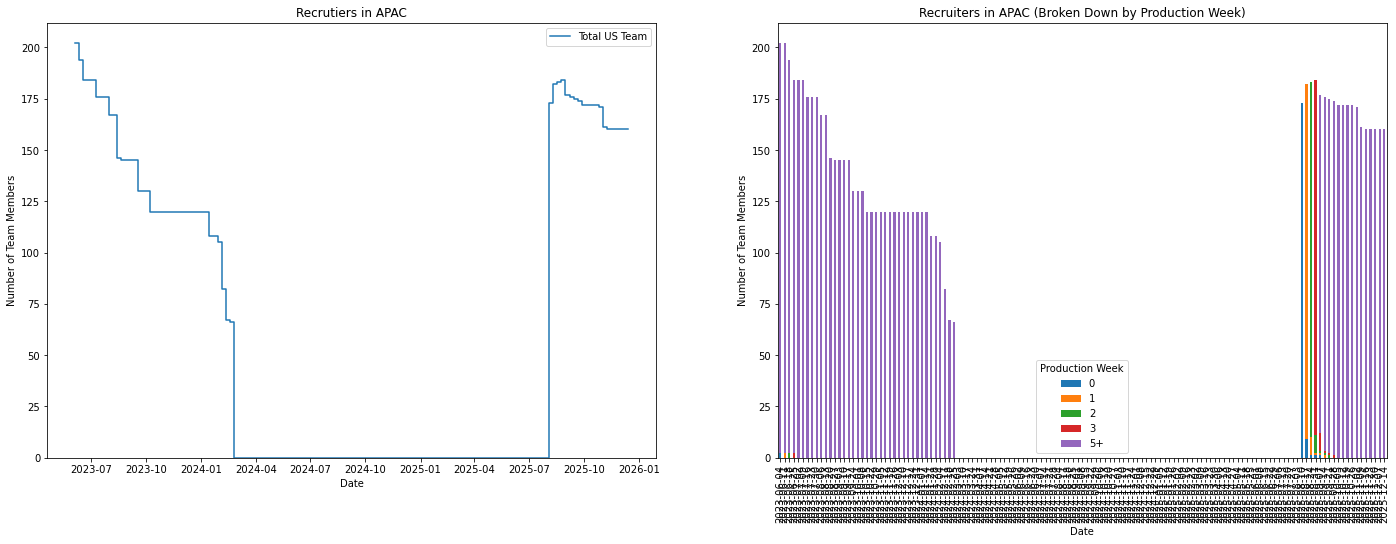

In [161]:
LL_agg_loc = LL_agg
LL_agg_loc['total_team_size'] = LL_agg_loc.loc[:, 0:50].sum(axis = 1)
LL_agg_loc['5+'] = LL_agg_loc.loc[:, 4:50].sum(axis = 1)
LL_agg_loc['date'] = pd.to_datetime(LL_agg_loc['date']).dt.date
fig, ax = plt.subplots(figsize = (24, 8), ncols = 2)

sns.lineplot(data = LL_agg_loc, x = 'date', y = 'total_team_size', drawstyle = 'steps-pre', ax = ax[0], label = 'Total US Team')
ax[0].set_ylim([0, None])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Team Members')
ax[0].set_title(f'Recrutiers in APAC')


LL_agg_loc[['date', 0, 1, 2, 3, '5+']].plot(kind = 'bar', stacked = True, x = 'date', ax = ax[1])
ax[1].legend(title = 'Production Week')

ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Team Members')
ax[1].set_title(f'Recruiters in APAC (Broken Down by Production Week)')

In [162]:
ac_oa_ptr
LL_agg_loc = LL_agg_loc[['date', 'global_capacity', 'Quarter']].assign(
    oas_achieved = (LL_agg_loc.global_capacity * ac_oa_ptr.values[0]).shift(ac_oa_lat.values[0])
)

In [166]:
dll2.reset_index()

,index,ac,oa,oe,os,pi
0,2023-06-04,1866.0,0.0,0.0,0.0,0.0
1,2023-06-11,1866.0,0.0,0.0,0.0,0.0
2,2023-06-18,1866.0,0.0,0.0,0.0,0.0
3,2023-06-25,1866.0,0.0,0.0,0.0,0.0
4,2023-07-02,1866.0,0.0,0.0,0.0,1549.0
...,...,...,...,...,...,...
129,2025-11-23,0.0,76.0,88.0,486.0,0.0
130,2025-11-30,0.0,76.0,88.0,0.0,0.0
131,2025-12-07,0.0,76.0,88.0,0.0,0.0
132,2025-12-14,0.0,76.0,88.0,0.0,0.0


ValueError: Could not interpret value `date` for parameter `x`

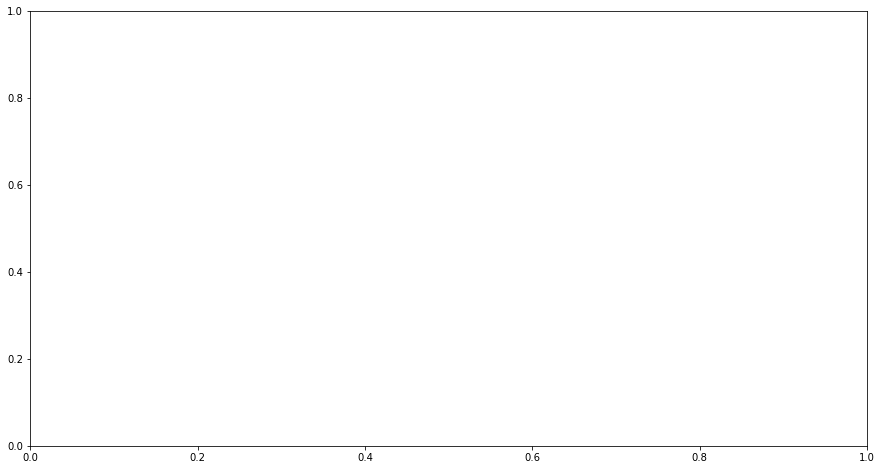

In [163]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.lineplot(data = dll2.reset_index(), y = 'oa', x = 'date', ax = ax, drawstyle = 'steps-pre')
sns.lineplot(data = LL_agg_loc, x = 'date', y = 'oas_achieved', ax = ax, drawstyle = 'steps-pre')